#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

import time

import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [ ]:
df = pd.read_csv('/datasets/taxi.csv')

In [ ]:
df.head(2)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14


Исходные данные начинаются с 1 марта 2018 года

In [ ]:
df.tail(2)

,datetime,num_orders
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


А заканчиваются 31 августа 2018 года

In [ ]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропущенных значений нет

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
df = df.set_index('datetime')

In [ ]:
print('Дата и время расположены в хронологическом порядке?')
print(df.index.is_monotonic)

Дата и время расположены в хронологическом порядке?
True


In [ ]:
df = df['2018-03':'2018-08'].resample('1H').sum()

In [ ]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Предсатвил столбец с датой и временем как индексы

## Анализ

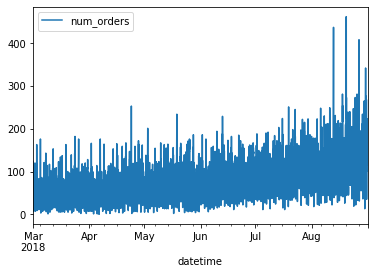

In [ ]:
df.plot()

Скользящее среднее:

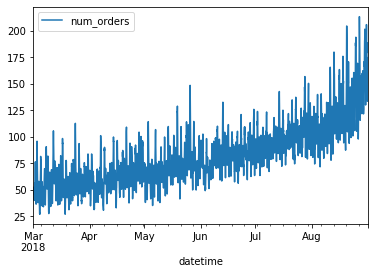

In [ ]:
df.rolling(10).mean().plot()

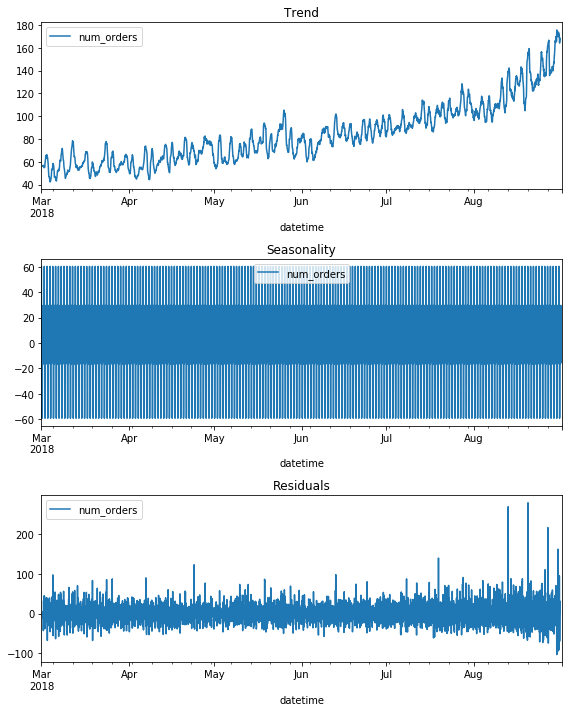

In [ ]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Из графиков виден тренд на увеличение числа заказов такси с приближением теплых месяцов

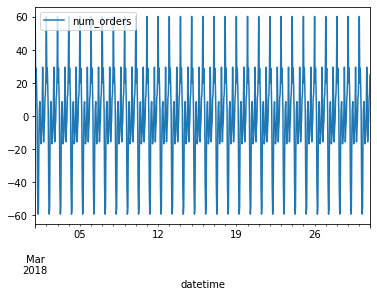

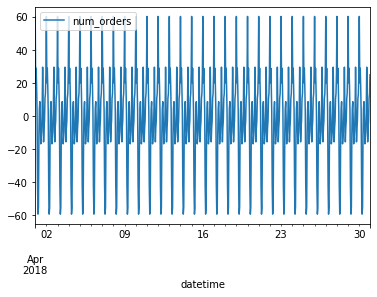

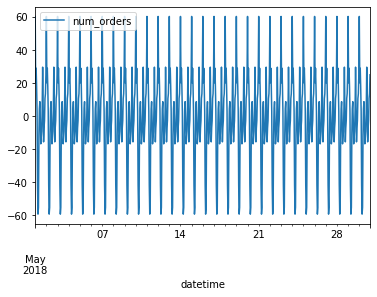

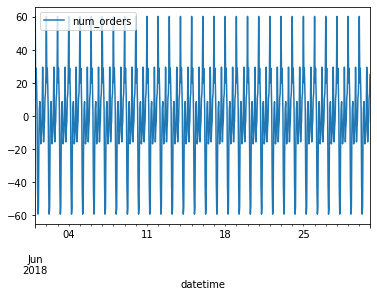

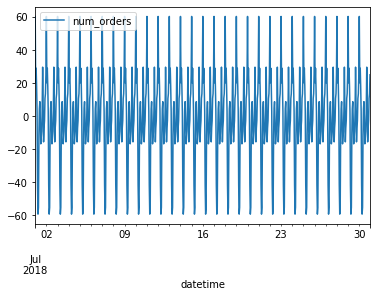

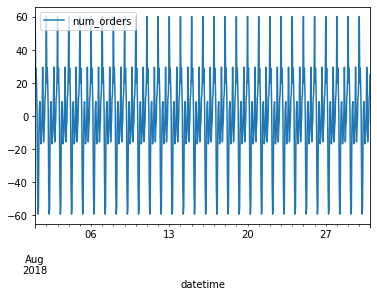

In [ ]:
decomposed.seasonal['2018-03-01':'2018-03-30'].plot()
decomposed.seasonal['2018-04-01':'2018-04-30'].plot()
decomposed.seasonal['2018-05-01':'2018-05-30'].plot()
decomposed.seasonal['2018-06-01':'2018-06-30'].plot()
decomposed.seasonal['2018-07-01':'2018-07-30'].plot()
decomposed.seasonal['2018-08-01':'2018-08-30'].plot()


Распределения заказов такси в течении рассматриваемых месяцов схожи между собой

Более подробный анализ исходых данных:

**Сезонность дня недели**

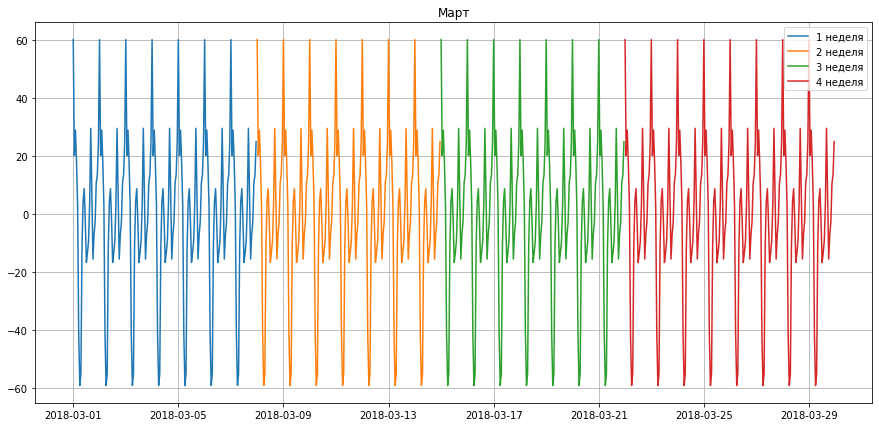

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Март')
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-07'], label='1 неделя')
plt.plot(decomposed.seasonal['2018-03-08':'2018-03-14'], label='2 неделя')
plt.plot(decomposed.seasonal['2018-03-15':'2018-03-21'], label='3 неделя')
plt.plot(decomposed.seasonal['2018-03-22':'2018-03-29'], label='4 неделя')
plt.legend()
plt.grid()
plt.show()

Сезонности по дню недели не наблюдается, по крайней мере визуально. То есть в выходные и будние дни продажи схожи

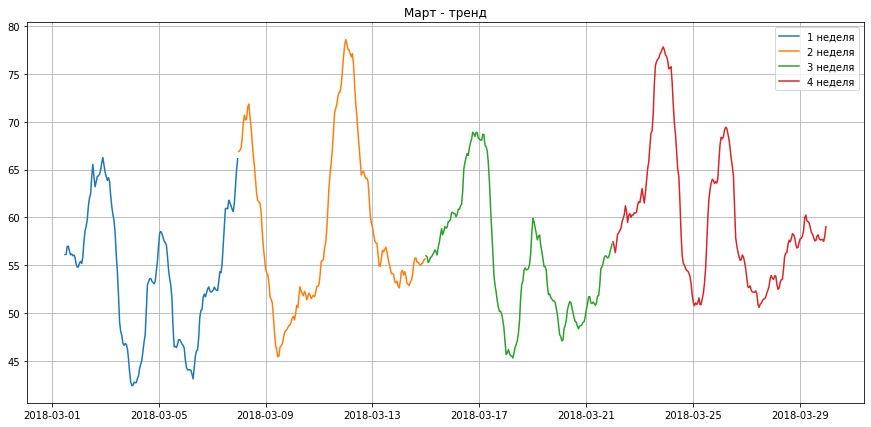

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Март - тренд')
plt.plot(decomposed.trend['2018-03-01':'2018-03-07'], label='1 неделя')
plt.plot(decomposed.trend['2018-03-08':'2018-03-14'], label='2 неделя')
plt.plot(decomposed.trend['2018-03-15':'2018-03-21'], label='3 неделя')
plt.plot(decomposed.trend['2018-03-22':'2018-03-29'], label='4 неделя')
plt.legend()
plt.grid()
plt.show()

Внутри месяца наблюдается тренд - к концумесяца в целом больше заказов. Также видно, что по субботам заказов больше, чем в другие дни.

**Внутрисуточная сезонность**

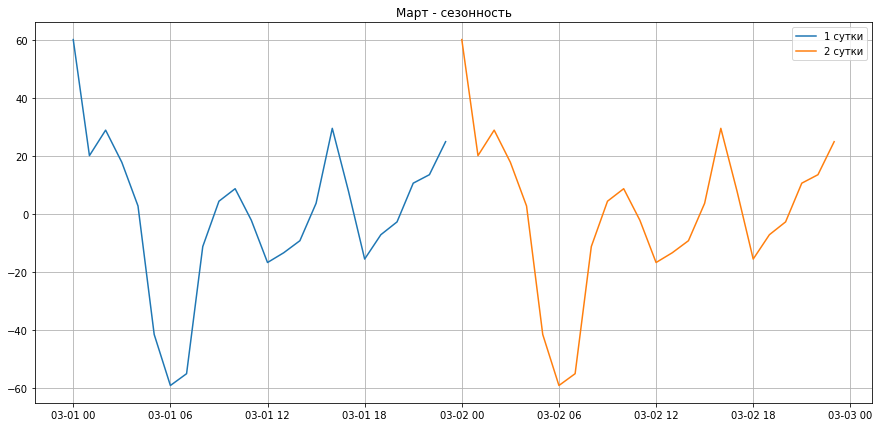

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Март - сезонность')
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-01'], label='1 сутки')
plt.plot(decomposed.seasonal['2018-03-02':'2018-03-02'], label='2 сутки')
plt.legend()
plt.grid()
plt.show()

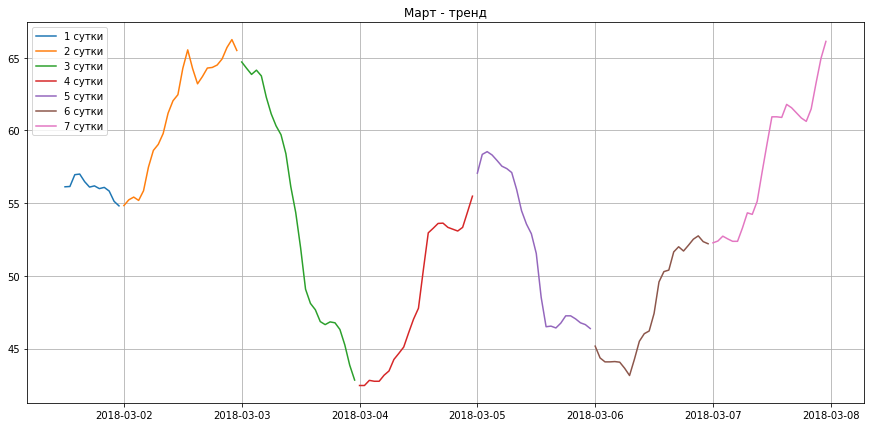

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Март - тренд')
plt.plot(decomposed.trend['2018-03-01':'2018-03-01'], label='1 сутки')
plt.plot(decomposed.trend['2018-03-02':'2018-03-02'], label='2 сутки')
plt.plot(decomposed.trend['2018-03-03':'2018-03-03'], label='3 сутки')
plt.plot(decomposed.trend['2018-03-04':'2018-03-04'], label='4 сутки')
plt.plot(decomposed.trend['2018-03-05':'2018-03-05'], label='5 сутки')
plt.plot(decomposed.trend['2018-03-06':'2018-03-06'], label='6 сутки')
plt.plot(decomposed.trend['2018-03-07':'2018-03-07'], label='7 сутки')
plt.legend()
plt.grid()
plt.show()

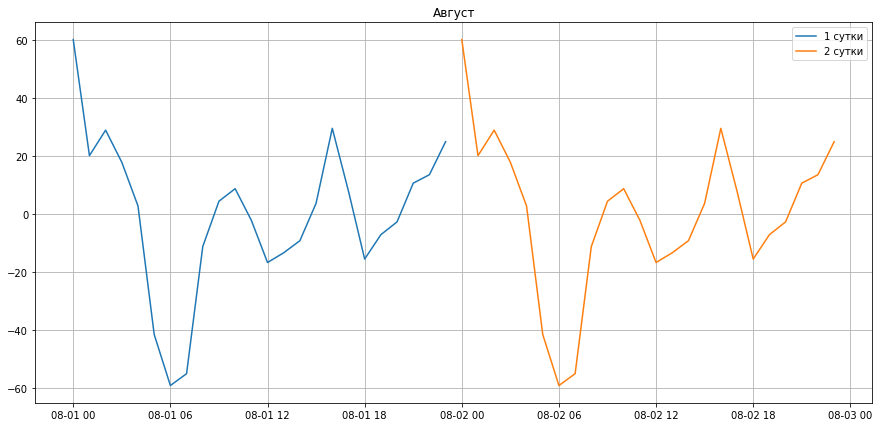

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Август')
plt.plot(decomposed.seasonal['2018-08-01':'2018-08-01'], label='1 сутки')
plt.plot(decomposed.seasonal['2018-08-02':'2018-08-02'], label='2 сутки')
plt.legend()
plt.grid()
plt.show()

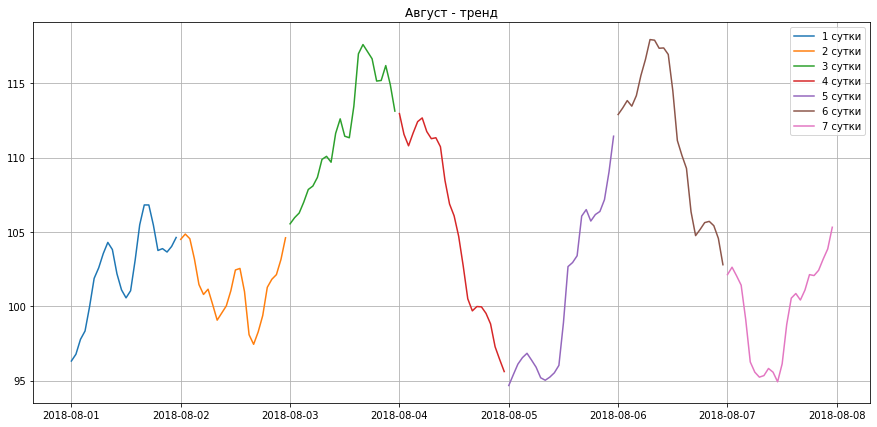

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Август - тренд')
plt.plot(decomposed.trend['2018-08-01':'2018-08-01'], label='1 сутки')
plt.plot(decomposed.trend['2018-08-02':'2018-08-02'], label='2 сутки')
plt.plot(decomposed.trend['2018-08-03':'2018-08-03'], label='3 сутки')
plt.plot(decomposed.trend['2018-08-04':'2018-08-04'], label='4 сутки')
plt.plot(decomposed.trend['2018-08-05':'2018-08-05'], label='5 сутки')
plt.plot(decomposed.trend['2018-08-06':'2018-08-06'], label='6 сутки')
plt.plot(decomposed.trend['2018-08-07':'2018-08-07'], label='7 сутки')
plt.legend()
plt.grid()
plt.show()

В независимости от месяца, наблюдается внутрисуточная сезонность: ночью заказов больше, а к 6 утра меньше всего. Тренд тоже показывает, что чаще всего ночью заказов больше

**Месячная сезонность**

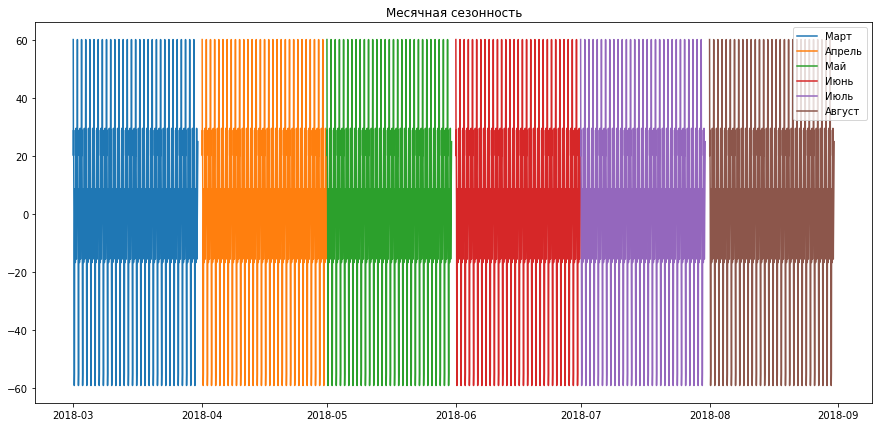

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Месячная сезонность')
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-30'], label='Март')
plt.plot(decomposed.seasonal['2018-04-01':'2018-04-30'], label='Апрель')
plt.plot(decomposed.seasonal['2018-05-01':'2018-05-30'], label='Май')
plt.plot(decomposed.seasonal['2018-06-01':'2018-06-30'], label='Июнь')
plt.plot(decomposed.seasonal['2018-07-01':'2018-07-30'], label='Июль')
plt.plot(decomposed.seasonal['2018-08-01':'2018-08-30'], label='Август')
plt.legend()
plt.show()

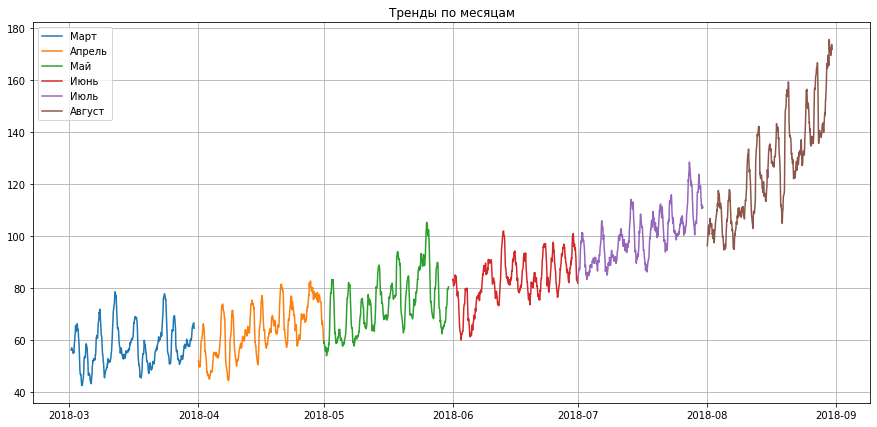

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Тренды по месяцам')
plt.plot(decomposed.trend['2018-03-01':'2018-03-30'], label='Март')
plt.plot(decomposed.trend['2018-04-01':'2018-04-30'], label='Апрель')
plt.plot(decomposed.trend['2018-05-01':'2018-05-30'], label='Май')
plt.plot(decomposed.trend['2018-06-01':'2018-06-30'], label='Июнь')
plt.plot(decomposed.trend['2018-07-01':'2018-07-30'], label='Июль')
plt.plot(decomposed.trend['2018-08-01':'2018-08-30'], label='Август')
plt.legend()
plt.grid()
plt.show()

Месячной сезонности не наблюдается. Но видно увеличение тренда продаж. Нельзя однозначно сказать за счёт чего оно: компания растёт или просто сезонность. Конечно же, зная бизнес изнутри - можно с лёгкгостью это определить. Но вот просто голо глядя на данные - на 100% нельзя утверждать тренд это или сезонность, не хвататет оснований.

## Обучение

In [ ]:
def make_features(data):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['lag'] = data['num_orders'].shift(1)
    data['rolling_mean'] = data['num_orders'].rolling(5).mean()

In [ ]:
make_features(df)

Добавил в исходные данные такие признаки, как день недели, час, lag (параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние), rolling_mean (аналог тренда, чем больше окно сглаживания, тем ровнее линия тренда)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
num_orders      4416 non-null int64
dayofweek       4416 non-null int64
hour            4416 non-null int64
lag             4415 non-null float64
rolling_mean    4412 non-null float64
dtypes: float64(2), int64(3)
memory usage: 367.0 KB


In [ ]:
df = df.tail(4412)


Убрал 4 первые строчки, т.к. в них в столбце rolling_mean были NaN <br>

In [ ]:
df

,num_orders,dayofweek,hour,lag,rolling_mean
datetime,,,,,
2018-03-01 04:00:00,43,3,4,66.0,77.8
2018-03-01 05:00:00,6,3,5,43.0,54.2
2018-03-01 06:00:00,12,3,6,6.0,39.6
2018-03-01 07:00:00,15,3,7,12.0,28.4
2018-03-01 08:00:00,34,3,8,15.0,22.0
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,174.6
2018-08-31 20:00:00,154,4,20,136.0,182.2
2018-08-31 21:00:00,159,4,21,154.0,174.6


In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [ ]:
target_train = train['num_orders']
features_train = train.drop(columns = 'num_orders')

target_test = train['num_orders']
features_test = train.drop(columns = 'num_orders')

Разделил данные на тренировочную и тестовую выборки

Модель Линейной регрессии:

In [ ]:
%%time

start = time.time() 

regressor = LinearRegression()

cv_RMSE_LR = (cross_val_score(regressor, features_train, target_train, cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
end_time_fit = time.time() - start
print('Среднее RMSE для Линейной регрессии =', cv_RMSE_LR)

Среднее RMSE для Линейной регрессии = 28.932435900566443
CPU times: user 31 ms, sys: 150 µs, total: 31.1 ms
Wall time: 54.2 ms


In [ ]:
results = []
results.append({'Модель': 'Линейная регрессия', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit,
                'RMSE': cv_RMSE_LR})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.053846,28.932436


Модель Случайного леса

In [ ]:
%%time

start = time.time() 

regressor = RandomForestRegressor() 
max_depth_list = [x for x in range(2, 5)]
est_list = [x for x in range(1, 3)]
hyperparams = [{'max_depth':max_depth_list,
                'n_estimators':est_list,
                'random_state':[12345]}]

tscv = TimeSeriesSplit(n_splits=8)
gsearch = GridSearchCV(estimator = regressor, param_grid=hyperparams, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

gsearch.fit(features_train, target_train)
print("Лучшие параметры:")
print()
print(gsearch.best_params_)
print()
print("Поиск по сетке:")
print()
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsearch.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

end_time_fit = time.time() - start

cv_RMSE_forest = (max(means)*-1) ** 0.5

Fitting 8 folds for each of 6 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Лучшие параметры:

{'max_depth': 4, 'n_estimators': 2, 'random_state': 12345}

Поиск по сетке:

30.574845 for {'max_depth': 2, 'n_estimators': 1, 'random_state': 12345}
29.996559 for {'max_depth': 2, 'n_estimators': 2, 'random_state': 12345}
29.018588 for {'max_depth': 3, 'n_estimators': 1, 'random_state': 12345}
28.171779 for {'max_depth': 3, 'n_estimators': 2, 'random_state': 12345}
27.465730 for {'max_depth': 4, 'n_estimators': 1, 'random_state': 12345}
26.516370 for {'max_depth': 4, 'n_estimators': 2, 'random_state': 12345}

CPU times: user 478 ms, sys: 3.86 ms, total: 482 ms
Wall time: 502 ms


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.5s finished


In [ ]:
results.append({'Модель': 'Случайный лес', 
                'Параметры': gsearch.best_params_, 
                'Время обучения': end_time_fit,
                'RMSE': cv_RMSE_forest})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.053846,28.932436
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",0.502047,26.516370


Модель дерева решений

In [ ]:
%%time

start = time.time()

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 7)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

tscv = TimeSeriesSplit(n_splits=8)
gsearch = GridSearchCV(estimator = regressor, param_grid=hyperparams, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

gsearch.fit(features_train, target_train)
print("Лучшие параметры:")
print()
print(gsearch.best_params_)
print()
print("Поиск по сетке:")
print()
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsearch.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

end_time_fit = time.time() - start

cv_RMSE_tree = (max(means)*-1) ** 0.5

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 8 folds for each of 5 candidates, totalling 40 fits
Лучшие параметры:

{'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}

Поиск по сетке:

30.817763 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
28.727811 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
26.753030 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
26.483661 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
25.574106 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}

CPU times: user 298 ms, sys: 3.98 ms, total: 302 ms
Wall time: 322 ms


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished


In [ ]:
results.append({'Модель': 'Дерево решений', 
                'Параметры': gsearch.best_params_, 
                'Время обучения': end_time_fit,
                'RMSE': cv_RMSE_tree})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.053846,28.932436
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",0.502047,26.516370
2,Дерево решений,"{'criterion': 'mse', 'max_depth': 6, 'random_s...",0.322065,25.574106


Модель CatBoost

In [ ]:
%%time

start = time.time()

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

tscv = TimeSeriesSplit(n_splits=8)
gsearch = GridSearchCV(estimator = regressor, param_grid=hyperparams, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

gsearch.fit(features_train, target_train)
print("Лучшие параметры:")
print()
print(gsearch.best_params_)
print()
print("Поиск по сетке:")
print()
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsearch.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

end_time_fit = time.time() - start

cv_RMSE_Cat = (max(means)*-1) ** 0.5

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  5.6min finished


Лучшие параметры:

{'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}

Поиск по сетке:

21.584030 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
23.179595 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
24.653810 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

CPU times: user 4min 43s, sys: 34.3 s, total: 5min 17s
Wall time: 5min 53s


In [ ]:
results.append({'Модель': 'CatBoost', 
                'Параметры': gsearch.best_params_, 
                'Время обучения': end_time_fit, 
                'RMSE': cv_RMSE_Cat})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.053846,28.932436
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",0.502047,26.516370
2,Дерево решений,"{'criterion': 'mse', 'max_depth': 6, 'random_s...",0.322065,25.574106
3,CatBoost,"{'learning_rate': 0.1, 'random_state': 12345, ...",353.655131,21.584030


Модель LGBM

In [ ]:
%%time

start = time.time()

model_LGBMR = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)
model_LGBMR.fit(features_train, target_train)

target_predict = model_LGBMR.predict(features_test)

end_time_fit = time.time() - start

final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 4.19 s, sys: 42 ms, total: 4.23 s
Wall time: 4.22 s


In [ ]:
results.append({'Модель': 'LGBM', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit,
                'RMSE': final_RMSE_LGBMR})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.053846,28.932436
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",0.502047,26.516370
2,Дерево решений,"{'criterion': 'mse', 'max_depth': 6, 'random_s...",0.322065,25.574106
3,CatBoost,"{'learning_rate': 0.1, 'random_state': 12345, ...",353.655131,21.584030
4,LGBM,NaN,4.222604,10.802742


Лучшее значение метрики RMSE у модели LGBM. Поэтому можно взять её в работу

## Тестирование

In [ ]:
target_predict

array([ 45.38251955,  16.30399044,  10.96698439, ..., 119.8137491 ,
        86.82053796, 113.1561064 ])

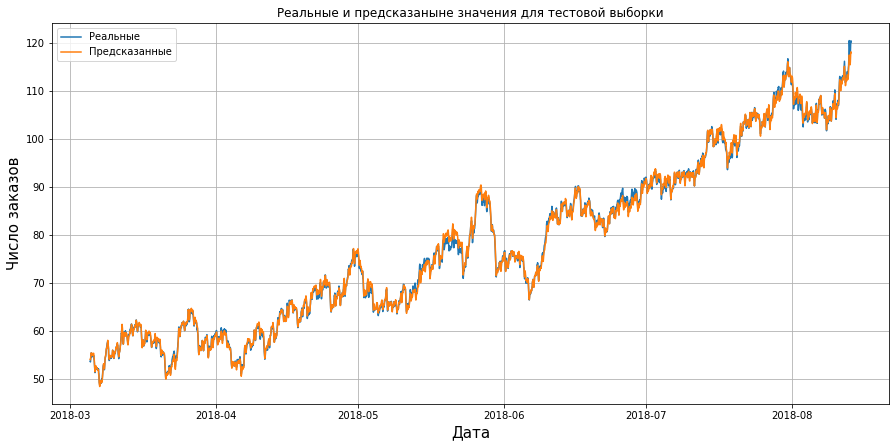

In [ ]:
plt.figure(figsize=(15, 7))
plt.title('Реальные и предсказаныне значения для тестовой выборки')
plt.plot(features_test.index, pd.DataFrame(target_test).rolling(100).mean() , label='Реальные')
plt.plot(features_test.index, pd.DataFrame(target_predict).rolling(100).mean() , label='Предсказанные')
plt.legend()
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Число заказов', fontsize=15)
plt.grid()
plt.show()

По графику видно, что предсказанные значения очень близки к исходным. Значит модель работает корректно